In [30]:
from utils import*
%matplotlib inline



####################################################################################################################################################
def resample_df(df, new_time):
    new_time_df = pd.DataFrame({'time':new_time})
    new_df = df.merge( new_time_df, on='time', how='outer', suffixes=('', ''), sort=True )
    new_df = new_df.interpolate(method='nearest')
    
    new_df = new_df.merge( new_time_df, on='time', how='inner', suffixes=('', ''), sort=True )
    return new_df
####################################################################################################################################################



####################################################################################################################################################
class NODE(object):
    n_marker = 3
    ################################################################################################################################################
    def __init__(self, markers_color, IDD=None):
        self.markers_color = markers_color
        self.IDD = IDD

        self.markers = None
        self.rssi = None
    ################################################################################################################################################
    def load_rssi(self, dataset_name, file_name, window_length=11):
        # Load data 
        rssi_file_path = get_rssi_file_path(dataset_name, file_name)       
        raw_df = pd.read_csv(
            rssi_file_path,                                                     # relative python path to subdirectory
            delimiter  = ';',                                                   # Tab-separated value file.
            usecols = ['IDD', 'Time', 'Ant/RSSI'],                              # Only load the three columns specified.
            parse_dates = ['Time'] )                                            # Intepret the birth_date column as a date      

        # self.rssi.loc[ self.rssi.IDD != self.IDD,'rssi'] = np.nan
        raw_df = raw_df.loc[ raw_df['IDD'] == self.IDD, :]
        self.rssi = pd.DataFrame({ 'rssi': raw_df['Ant/RSSI'].str.replace('Ant.No 1 - RSSI: ', '').astype(int) })

        # Processing
        self.rssi = self.rssi.rolling(window_length, axis=0).median()   # Smoothing
        self.rssi = self.rssi.ffill(axis=0).bfill(axis=0)               # Gap Filling
         
        # Time
        date_time = pd.to_datetime( raw_df['Time'] , format=datime_format)
        self.rssi['time'] = [ np.round( (datetime.combine(date.min, t.time())-datetime.min).total_seconds(), 2) for t in date_time]

        return
    ################################################################################################################################################
    def load_markers(self, dataset_name, file_name, window_length=11):   
      
        # Load raw data 
        motion_file_path = get_markers_file_path(dataset_name, file_name + '_' + self.markers_color)  
        self.markers = pd.read_csv( motion_file_path, delimiter="\t", header=None, dtype=np.float64)
                
        # Processing
        self.markers = self.markers.rolling(window_length, axis=0).mean()    # Gap filling
        self.markers = self.markers.ffill(axis=0).bfill(axis=0)              # Smoothing

        # Time
        time_file_path = get_time_file_path(dataset_name, file_name)    
        with open(time_file_path , 'r') as f:  lines = f.read().splitlines() 
        date_time = pd.to_datetime( lines , format=datime_format)
        self.markers['time'] = [ (datetime.combine(date.min, t.time())-datetime.min).total_seconds() for t in date_time]
        
        return
    ################################################################################################################################################
    def shift_time(self, shift):
        self.markers.time -= shift
        if self.rssi is not None: self.rssi.time -= shift
        return
    ################################################################################################################################################
    def center(self, window_length=7, polyorder=1):
        markers_npy = self.markers.drop(['time'], axis=1).to_numpy()
        markers_npy = markers_npy.reshape(np.shape(markers_npy)[0], -1, 3)
        center = np.mean(markers_npy, axis=1) 
        
        center = signal.savgol_filter( center, window_length=window_length, polyorder=polyorder, axis=0)            
        return center
    ################################################################################################################################################    
    def norm(self, window_length=7, polyorder=1):
        markers_npy = self.markers.drop(['time'], axis=1).to_numpy()
        # markers_npy = signal.savgol_filter( markers_npy, window_length=window_length, polyorder=polyorder, axis=0)  

        markers_npy =  markers_npy.reshape(np.shape(markers_npy)[0], -1, 3)
        v1 = markers_npy[:,1,:] - markers_npy[:,0,:]
        v2 = markers_npy[:,2,:] - markers_npy[:,0,:] 
        norm = np.cross( v1, v2)
        norm[ norm[:,2]<0, :] *= -1 
        norm = signal.savgol_filter( norm, window_length=window_length, polyorder=polyorder, axis=0)  
        norm = norm / ( np.reshape(np.linalg.norm(norm, axis=1), (-1,1)) * np.ones((1,3))) 
        return norm
####################################################################################################################################################
class SYSTEM(object):
    ################################################################################################################################################
    def __init__(self, system_info = None):
        self.reader = None
        self.tags = list()

        if system_info is not None:
            system_info_ = system_info.copy()
            reader_markers_color = system_info_.pop('reader')
            self.add_reader(reader_markers_color)
            for IDD,markers_color in system_info_.items(): self.add_tag(markers_color, IDD)
        return
    ################################################################################################################################################
    def add_reader(self, reader_markers_color):
        self.reader = NODE( reader_markers_color )
        return
    ################################################################################################################################################
    def add_tag(self, markers_color, IDD):
        self.tags.append( NODE(markers_color, IDD) )   
        return               
    ################################################################################################################################################
    def load(self, dataset_name, file_name):
        self.dataset_name = dataset_name
        self.file_name = file_name

        # Loading + time shift
        self.reader.load_markers(dataset_name, file_name) 
        start_time = self.reader.markers.time.iloc[0]

        for i,tag in enumerate(self.tags):            
            self.tags[i].load_markers(dataset_name, file_name)
            self.tags[i].load_rssi(dataset_name, file_name) 
            start_time = min( start_time, tag.rssi.time.iloc[0])

        self.reader.shift_time(start_time)    
        for i,tag in enumerate(self.tags): self.tags[i].shift_time(start_time)
        
        return
    ################################################################################################################################################
    def get_rssi_data(self, window_length=5):
        rssi = pd.DataFrame({'time':self.tags[0].rssi.time})
        for i, tag in enumerate(self.tags):
            tag_rssi = sys.tags[i].rssi.rename({'rssi':'rssi_'+str(i)}, axis=1)
            rssi = rssi.merge( tag_rssi, on='time', how='outer', suffixes=('', ''), sort=True )

        rssi.fillna(method='ffill', axis=0, inplace=True)             

        return rssi
    ################################################################################################################################################
    def get_motion_data(self, window_length=5):   
        # Modify this function for different targeted movements
        motion = pd.DataFrame({'time':self.reader.markers.time})

        N = 10
        ref_center = self.reader.center()
        ref_norm = self.reader.norm()            
        ref_center = np.ones(np.shape(ref_center)) * np.mean(ref_center[:N], axis=0)
        ref_norm = np.ones(np.shape(ref_norm)) * np.mean(ref_norm[:N], axis=0)

        for i, tag in enumerate(self.tags):
            motion['distance_'+str(i)] = np.linalg.norm( ref_center - tag.center(), axis=1)
            motion['misalignment_'+str(i)] = ( np.arccos(np.abs(np.sum(np.multiply( ref_norm, tag.norm()), axis=1)) ) * 180/np.pi )

        motion.fillna(method='ffill', axis=0, inplace=True)  

        return motion
    ################################################################################################################################################
    def get_data(self, window_length=11, save=False):
        rssi = self.get_rssi_data()
        motion = self.get_motion_data()

        data = rssi.merge( motion, on='time', how='outer', suffixes=('', ''), sort=True )
        data = data.interpolate(method='nearest')
        
        new_time = rssi.time
        new_time = new_time[ motion.time.iloc[0] < new_time]
        new_time = new_time[ new_time < motion.time.iloc[-1] ]
        data = data.merge( new_time, on='time', how='inner', suffixes=('', ''), sort=True )

#         for i in range(len(self.tags)):
#             data = data.astype({ 'rssi_'+str(i) : int, 'distance_'+str(i) : float, 'misalignment_'+str(i) : float })                

        data = data.rolling(11, axis=0).mean()      # Smoothing
        data = data.ffill(axis=0).bfill(axis=0)     # Gap Filling

        if save:
            dataset_file_path = get_dataset_file_path(self.dataset_name, self.file_name)
            create_folder(dataset_file_path)
            data.to_pickle( dataset_file_path )  
            
        return data
####################################################################################################################################################


In [3]:
%matplotlib inline
from utils import *
from pycaret.regression import*

In [2]:
def get_data(dataset_name, file_names_range, target, features, win_size=None, step_size_ratio=1):
    
    dataset_df = pd.DataFrame()        
    for n in file_names_range:        
        file_path = get_dataset_file_path(dataset_name, 'record_'+"{0:0=2d}".format(n)) 
        data = pd.read_pickle( file_path )  
        target_df = data.filter(regex=target, axis=1)
        features_df = data.filter(regex=features, axis=1)

        if win_size is not None:
            data_df = pd.DataFrame()    
            step_size = int(step_size_ratio * win_size)
                
            for i in range(0, len(features_df)- win_size, step_size):
                row = { target: target_df.loc[i+win_size-1, target]}
                
                for feature_name in features_df.columns: 
                    for j in range(win_size):
                        row.update({ feature_name + "{0:0=2d}".format(j): features_df.loc[i+j, feature_name] })
                data_df = data_df.append(row, ignore_index=True)
        else:
            data_df = pd.concat([features_df, target_df], axis=1)
        
        dataset_df = dataset_df.append(data_df, ignore_index=True)
    
    dataset_df = dataset_df.rename({target:'target'}, axis=1)
    return dataset_df

# Data

#### Load Data

In [3]:
dataset_name = 'dataset_01' 
target = 'distance_1' 
features = 'rssi' 
win_size = None
step_size_ratio = 1

# Tarining
file_names_range = np.arange(20)
data = get_data( dataset_name, file_names_range, target, features, win_size=win_size, step_size_ratio=step_size_ratio )

# Test
file_names_range = np.arange(20,25)
data_unseen = get_data( dataset_name, file_names_range, target, features, win_size=win_size, step_size_ratio=step_size_ratio )

display(data)

,rssi_0,rssi_1,target
0,111.818182,143.727273,0.260033
1,111.818182,143.727273,0.260033
2,111.818182,143.727273,0.260033
3,111.818182,143.727273,0.260033
4,111.818182,143.727273,0.260033
...,...,...,...
7719,81.090909,126.181818,0.270657
7720,81.636364,128.818182,0.269414
7721,82.181818,131.454545,0.268346
7722,82.727273,134.090909,0.267059


# Regression

In [4]:
exp_reg = setup(data,
#                 train_size = .9,
                target = 'target', 
#                 normalize = True, 
                session_id = 20
                )   

 
Setup Succesfully Completed!


,Description,Value
0,session_id,20
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(7724, 3)"
4,Missing Values,False
5,Numeric Features,2
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


#### Model

In [5]:
model = tune_model('lightgbm')
# model = create_model('rf')

NRMSE = round(exp_reg[-1][-1][-1].RMSE.Mean / np.mean(data.target) * 100, 2)
print(NRMSE)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0321,0.0018,0.0426,0.8653,0.0318,0.1063
1,0.0349,0.0022,0.0473,0.8338,0.0351,0.1149
2,0.0347,0.0021,0.0455,0.8518,0.0340,0.1148
3,0.0362,0.0024,0.0492,0.8035,0.0367,0.1213
4,0.0326,0.0018,0.0425,0.8596,0.0315,0.1050
5,0.0327,0.0018,0.0424,0.8589,0.0313,0.1011
6,0.0370,0.0025,0.0499,0.8155,0.0369,0.1205
7,0.0331,0.0021,0.0454,0.8408,0.0334,0.1055
8,0.0328,0.0019,0.0433,0.8635,0.0322,0.1074
9,0.0339,0.0021,0.0456,0.8390,0.0340,0.1134


13.03


In [10]:
# plot_model(model, plot='error')
# plot_model(model, plot='feature')

#### Test

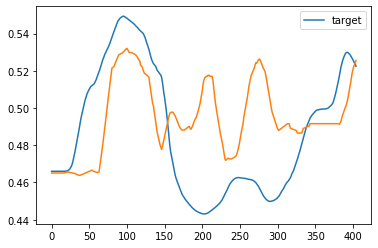

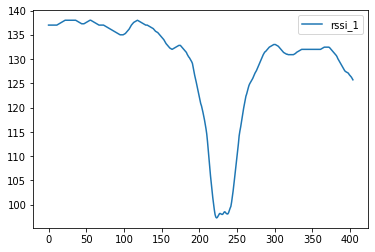

In [7]:
data_unseen = get_data( dataset_name, [7], target, features, win_size=win_size, step_size_ratio=step_size_ratio )
# data_unseen.plot(y='target')
# ax = data_unseen.plot(y='rssi_0')
# data_unseen.plot(y='rssi_1', ax=ax)

prediction = predict_model(model, data=data_unseen)

window_length = 17
labels = prediction.Label
labels = labels.rolling(window_length, axis=0).mean()    # Smoothing
labels = labels.ffill(axis=0).bfill(axis=0)              # Gap Filling
    
ax = prediction.plot(y='target')
labels.plot(y='Label', ax=ax)
data_unseen.plot(y='rssi_1')
plt.show()


In [ ]:
# save_experiment(get_result_file_path('res_00'))

#### Compare Regressors

In [14]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.031300,0.001900,0.043900,0.761700,0.031300,0.082200
1,CatBoost Regressor,0.032400,0.001900,0.044100,0.759900,0.031400,0.085100
2,Random Forest,0.028000,0.002000,0.044800,0.751900,0.031800,0.072900
3,Extra Trees Regressor,0.028800,0.002100,0.046300,0.735300,0.032900,0.075000
4,K Neighbors Regressor,0.029800,0.002200,0.046500,0.731700,0.033200,0.078400
5,Extreme Gradient Boosting,0.037200,0.002500,0.049700,0.694600,0.035500,0.098700
6,Gradient Boosting Regressor,0.037300,0.002500,0.049900,0.693100,0.035600,0.098900
7,Decision Tree,0.030200,0.002900,0.053500,0.644800,0.038100,0.078400
8,AdaBoost Regressor,0.045300,0.003300,0.057400,0.594300,0.040900,0.119300
9,Support Vector Machine,0.048400,0.003500,0.059400,0.565700,0.042500,0.130300


In [4]:
from sklearn import*
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [5]:
X_train = data.filter(regex='rssi', axis=1).to_numpy()
Y_train = data.filter(regex='target', axis=1).to_numpy()
X_validation = data_unseen.filter(regex='rssi', axis=1).to_numpy()
Y_validation = data_unseen.filter(regex='target', axis=1).to_numpy()

In [8]:
# n_samples, n_features = 10, 5

# regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
# regr.fit(X, y)
# Pipeline(steps=[('standardscaler', StandardScaler()),
#                 ('svr', SVR(epsilon=0.2))])

In [ ]:
# # model = make_pipeline(StandardScaler(), SVR())
# model = svm.SVR()
# grid_params = { 
#     'kernel' : ['poly', 'rbf'],
#     'degree' : [2] 
# }

# clf = model_selection.GridSearchCV( model, grid_params )
# clf.fit( X_train, Y_train )
# model = clf.best_estimator_
# best_params = clf.best_params_
       
# predictions = model.predict( X_validation )    

In [9]:
# model = make_pipeline(StandardScaler(), SVR())
model = svm.SVR(kernel='poly', degree=2)
model.fit( X_train, Y_train )
       
predictions = model.predict( X_validation )    

C:\Users\mixil\anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Hyperparameter Tuning for Window-Sliding:

In [ ]:
def test(win_size, step_size_ratio)
    data = get_data(
        dataset_name = 'dataset_01', 
        file_names_range = np.arange(20), 
        target = 'distance_0', 
        features = 'rssi', 
        win_size = win_size, 
        step_size_ratio = step_size_ratio)

    exp_reg = setup(data, 
              target = 'target', 
              normalize = True, 
              session_id = 100)   

    model = tune_model('rf')
    model_rmse = exp_reg[9][8][1].RMSE.Mean
    return model_rmse

In [70]:
best_result = dict( win_size=None, step_size_ratio=None)
min_rmse = test(None, None)

for win_size in [10, 20]:
    for step_size_ratio in [.25, .5, .75, 1]:
        test(win_size, step_size_ratio)
        if model_rmse < min_rmse: best_result.update({'win_size':win_size, 'step_size_ratio':step_size_ratio})

print(best_result)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0403,0.0031,0.0554,0.5275,0.0387,0.0970
1,0.0491,0.0038,0.0620,0.5753,0.0456,0.1530
2,0.0483,0.0043,0.0656,0.2679,0.0471,0.1341
3,0.0483,0.0037,0.0606,0.5677,0.0433,0.1282
4,0.0497,0.0047,0.0683,0.4076,0.0498,0.1485
5,0.0486,0.0038,0.0617,0.4269,0.0443,0.1279
6,0.0336,0.0020,0.0452,0.7171,0.0317,0.0837
7,0.0497,0.0050,0.0704,0.4416,0.0491,0.1148
8,0.0374,0.0022,0.0469,0.6599,0.0324,0.0863
9,0.0418,0.0028,0.0525,0.5632,0.0377,0.1116
